Set Working Directory

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research/v2'

Packages

In [2]:
import yaml
import numpy as np

import src.experiments.file_io as file_io
import src.experiments.aggregate_average as core
import src.experiments.shared as shared
import src.viz.aggregate_average as viz

from pathlib import Path
from datetime import datetime

from src.utils.reproducibility import set_global_seed
from src.utils.metadata import get_git_commit_hash
from src.utils.config_loading import load_yaml_config

Functions

In [3]:
def compute_score_pair_errors(gt_score_pairs, pred_score_pairs):
    # calculate mean absolute error
    mean_error = np.mean(np.abs(gt_score_pairs - pred_score_pairs))

    # calculate ground truth std
    ground_truth_std = np.std(gt_score_pairs, ddof=1)
    
    return mean_error, ground_truth_std

In [4]:
def evaluate_error_by_missing_count(test_x, test_y, test_predictions, dims=14):
    _, cur_score = core.split_encoding_and_scores(test_x, dims=dims)
    future_score_gt = test_y

    mean_errors_list = []
    ground_truth_std_list = []
    ground_truth_dict = {}
    missing_counts = list(range(0, dims))

    for n in missing_counts:
        filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
        filtered_gt = future_score_gt[filter_mask]
        filtered_pred = test_predictions[filter_mask]

        ground_truth_dict[str(n)] = filtered_gt

        if filtered_gt.size == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
        mean_errors_list.append(mean_error)
        ground_truth_std_list.append(std_dev)

    return missing_counts, mean_errors_list, ground_truth_std_list, ground_truth_dict

Script

In [5]:
config_path = "config/experiments/20250624_aggavg_1.yaml"

In [6]:
# load configuration
config = load_yaml_config(config_path)
run_type = config["settings"]["type"] # repeat vs non-repeat
device = config["settings"]["device"] # cpu or cuda
seed = config["settings"]["seed"]

data_source = config["data"]["data_source"] # npz file with multiple arrays
model_source = config["data"]["model_source"] # path to the model
output_destination = config["data"]["destination_base"]

In [7]:
## general setup
figure_names = ["accuracy_assessment.png", "aggregate_average.png"]


## set global seed
set_global_seed(seed)

## get git commit hash
git_commit_hash = get_git_commit_hash()

In [8]:
## load model
model = shared.load_model(model_source, device=device)

In [9]:
## read data
test_data = np.load("old_data/next_step_test_data_encoded.npy")
test_data = core.filter_rows_by_sum(test_data, slice(0, 14), 1)
from src.training.training_torch import split_input_target

test_x, test_y = split_input_target(test_data)
test_predictions = shared.inference(model, test_x)
test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()

In [10]:
test_x.shape, test_y.shape, test_predictions.shape

((960116, 42), (960116, 14), (960116, 14))

In [11]:
## filter by session type
repeat_mask = core.assign_repeat(test_x)

In [12]:
repeat_mask.sum()

np.int64(956635)

In [13]:
# if run type is repeat, filter for only repeat sessions
# if run type is non-repeat, filter for only non-repeat sessions
if run_type == "repeat":
    test_x = test_x[repeat_mask]
    test_y = test_y[repeat_mask]
    test_predictions = test_predictions[repeat_mask]
elif run_type == "non-repeat":
    test_x = test_x[~repeat_mask]
    test_y = test_y[~repeat_mask]
    test_predictions = test_predictions[~repeat_mask]

In [14]:
test_x.shape, test_y.shape, test_predictions.shape

((956635, 42), (956635, 14), (956635, 14))

(1) find ground truth std and prediction MAE

In [15]:
# encoding, cur_score = core.split_encoding_and_scores(test_x, dims=14)
# future_score_gt = test_y

# mean_errors_list = []
# ground_truth_std_list = []
# ground_truth_dict = {}
missing_counts = list(range(0, 14))

In [16]:
# for n in missing_counts:
#     filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
#     filtered_encoding = encoding[filter_mask]
#     filtered_gt = future_score_gt[filter_mask][filtered_encoding == 1]
    # filtered_pred = test_predictions[filter_mask][filtered_encoding == 1]

    # ground_truth_dict[str(n)] = filtered_gt

    # if filtered_gt.size == 0:
    #     mean_errors_list.append(np.nan)
    #     ground_truth_std_list.append(np.nan)
    #     continue

    # mean_error, std_dev = core.compute_errors(filtered_gt, filtered_pred)
    # mean_errors_list.append(mean_error)
    # ground_truth_std_list.append(std_dev)

In [17]:
# # plot error by missing count and save figure
# viz.plot_error_by_missing_count(
#     missing_counts=missing_counts,
#     std=ground_truth_std_list,
#     error=mean_errors_list,
#     run_type=run_type
# )

(2) predict scores based on strategy

In [18]:
# ground truth original scores
encoding, scores_gt = core.split_encoding_and_scores(test_x, dims=14)

In [19]:
# ground truth future scores
future_scores_gt = test_y

In [20]:
scores_gt.shape, future_scores_gt.shape

((956635, 28), (956635, 14))

In [21]:
scores_gt[:3]

array([[0.526     , 0.47399998, 0.02      , 0.98      , 0.148     ,
        0.852     , 0.375     , 0.625     , 0.129     , 0.871     ,
        0.        , 1.        , 0.022     , 0.978     , 0.        ,
        0.        , 0.08      , 0.92      , 0.454     , 0.546     ,
        0.8       , 0.19999999, 0.127     , 0.873     , 0.081     ,
        0.919     , 1.        , 0.        ],
       [0.526     , 0.47399998, 0.11      , 0.89      , 1.        ,
        0.        , 0.4       , 0.6       , 0.168     , 0.832     ,
        0.013     , 0.987     , 0.222     , 0.778     , 0.        ,
        1.        , 0.307     , 0.69299996, 0.485     , 0.515     ,
        0.64      , 0.36      , 0.364     , 0.63600004, 0.644     ,
        0.356     , 0.2       , 0.8       ],
       [1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 0.95      , 0.05000001, 0.        ,
        0.        , 1.    

In [22]:
future_scores_gt[:3]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.081, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.5  , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [23]:
# best
prediction_list = []
rows, cols = test_y.shape
_, scores = core.split_encoding_and_scores(test_x, dims=14)
for domain in missing_counts:
    single_encoding = core.create_single_encoding(rows, cols, domain)
    tmp_single = core.add_encoding(scores, single_encoding)
    single_prediction = shared.inference(model, tmp_single)
    prediction_list.append(single_prediction[:, domain])

prediction_matrix = np.column_stack(prediction_list)
difference = prediction_matrix - scores[:, ::2]

# find max indices
max_values, max_indices = shared.max_prediction_from_difference_pair(difference, prediction_matrix, scores, run_type)
# reconstruct matrices
future_scores_best, best_encoding = core.reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

In [24]:
# random
random_encoding, future_scores_random = core.find_random_predictions(
    model=model,
    data=scores_gt,
    run_type=run_type
)

In [25]:
average_gt_list = []
average_best_list = []
average_random_list = []

std_gt_list = []
std_best_list = []
std_random_list = []

In [26]:
def compute_averages_and_stds(cur_scores, future_scores, masks):
    """
    masks: first mask for missing count, second mask for location of target value (encoding == 1)
    """
    difference = future_scores - cur_scores
    difference_filtered = core.filter_with_masks(difference, masks)

    average = np.mean(difference_filtered)
    std_dev = np.std(difference_filtered)

    return average, std_dev

In [27]:
# for n in missing_counts:
#     # get missing mask
#     missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
#     # get original data that fit the missing count
#     # call helper calculate ground truth
#     compute_averages_and_stds(scores_gt, future_scores_gt, missing_mask)
#     # call helper find random predictions and encoding
#     future_scores_random = core.find_random_predictions(
#         model=model,
#         data=test_x,
#         run_type=run_type
#     )
#     # call helper calculate
#     compute_averages_and_stds(scores_gt, future_scores_random, missing_mask)
#     # call helper find best predictions and encoding
#     future_scores_best, best_encoding = core.find_best_predictions(
#         model=model,
#         data=test_x,
#         run_type=run_type
#     )
#     # call helper calculate
#     pass

In [28]:
for n in missing_counts:
    missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
    
    scores_gt_tmp = scores_gt[missing_mask][:, ::2]

    future_scores_gt_tmp = future_scores_gt[missing_mask]
    future_scores_best_tmp = future_scores_best[missing_mask]
    future_scores_random_tmp = future_scores_random[missing_mask]

    difference_gt = future_scores_gt_tmp - scores_gt_tmp
    difference_gt = difference_gt[encoding[missing_mask] == 1]
    difference_best = future_scores_best_tmp - scores_gt_tmp
    difference_best = difference_best[best_encoding[missing_mask] == 1]
    difference_random = future_scores_random_tmp - scores_gt_tmp
    difference_random = difference_random[random_encoding[missing_mask] == 1]

    average_gt = np.mean(difference_gt)
    average_best = np.mean(difference_best)
    average_random = np.mean(difference_random)

    std_gt = np.std(difference_gt)
    std_best = np.std(difference_best)
    std_random = np.std(difference_random)

    average_gt_list.append(average_gt)
    average_best_list.append(average_best)
    average_random_list.append(average_random)

    std_gt_list.append(std_gt)
    std_best_list.append(std_best)
    std_random_list.append(std_random)

In [29]:
random_encoding[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [30]:
test_x[0, 14:]

array([0.526     , 0.47399998, 0.02      , 0.98      , 0.148     ,
       0.852     , 0.375     , 0.625     , 0.129     , 0.871     ,
       0.        , 1.        , 0.022     , 0.978     , 0.        ,
       0.        , 0.08      , 0.92      , 0.454     , 0.546     ,
       0.8       , 0.19999999, 0.127     , 0.873     , 0.081     ,
       0.919     , 1.        , 0.        ], dtype=float32)

In [31]:
test_y[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.081, 0.   ], dtype=float32)

In [32]:
test_x[missing_mask]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]], shape=(80, 42), dtype=float32)

In [33]:
average_best_list

[np.float64(0.07141624671920725),
 np.float64(0.05383774746095314),
 np.float64(0.052733244750743744),
 np.float64(0.04513173623788254),
 np.float64(0.041469924073482184),
 np.float64(0.04625416694192471),
 np.float64(0.043550000751269205),
 np.float64(0.04321711525134392),
 np.float64(0.04155726181623959),
 np.float64(0.030606894451078816),
 np.float64(0.05418108218454512),
 np.float64(0.030664874996379037),
 np.float64(0.02428218586542664),
 np.float64(0.026693455292843282)]

In [34]:
import matplotlib.pyplot as plt

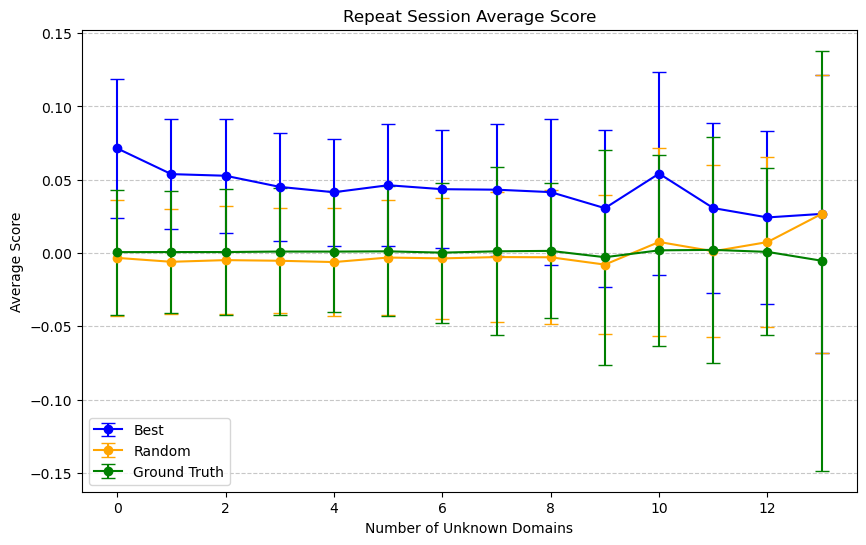

In [35]:
# Define x-axis values (number of unknown domains)
# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(missing_counts, average_best_list, yerr=std_best_list, label="Best", fmt='-o', capsize=5, color="blue")
plt.errorbar(missing_counts, average_random_list, yerr=std_random_list, label="Random", fmt='-o', capsize=5, color="orange")
plt.errorbar(missing_counts, average_gt_list, yerr=std_gt_list, label="Ground Truth", fmt='-o', capsize=5, color="green")

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Score")
plt.title("Repeat Session Average Score")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [36]:
'''# get score pairs
gt_score_pairs = core.extract_score_pairs(gt_score_pairs)
pred_score_pairs = core.extract_score_pairs(pred_score_pairs)

# find valid score pairs
valid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])

# filter valid score pairs
gt_score_pairs = gt_score_pairs[valid_mask]
pred_score_pairs = pred_score_pairs[valid_mask]'''



'# get score pairs\ngt_score_pairs = core.extract_score_pairs(gt_score_pairs)\npred_score_pairs = core.extract_score_pairs(pred_score_pairs)\n\n# find valid score pairs\nvalid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])\n\n# filter valid score pairs\ngt_score_pairs = gt_score_pairs[valid_mask]\npred_score_pairs = pred_score_pairs[valid_mask]'